# Summary

This exercise pretends to implement a multilayer perceptron neural network from scratch.

Using the stanford dogs breed database and taking the multilayer perceptron architecture from deeplearning.ai specialization, I will try:

- implement a multiclass classification through Softmax output activation    layer.

- Implement mini-batches to improve the algorithm and try to avoid overfitting.

- Implement momentum to accelerate the cost minimization process.

- Fine tunning the hyperparameters and try different layers/neurons setups.

# Data preparation

credit to: Terrance Whitehurst

https://www.kaggle.com/twhitehurst3/stanford-dogs-keras-vgg16

This part of the code aims to prepare the data to train the neural network. It generates the folders that will contain the different images cropped to the same size, labelled and then encoded through a onehotencoder to prepare the labels accordingly to the requirements of the softmax output layer.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
global_path = '/content/drive/My Drive/Binary classification/'

In [ ]:
global_path

'/content/drive/My Drive/Binary classification/'

In [ ]:
import os
import math

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
import scipy

from skimage.io import imread
from skimage.transform import resize
from PIL import Image

from sklearn.model_selection import train_test_split

In [ ]:
def softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    A = expZ / expZ.sum(axis=0, keepdims=True)
    cache = Z
    return A, cache

In [ ]:
def softmax_backward(AL, Y, cache):
    
    Z = cache
    
    # Compute dZ
    dZ = AL - Y
    
    #assert(Z.shape == dZ.shape)
    
    return dZ

Create folders that will contain the cropped images for the selected breeds.


In [ ]:
%%time

# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation


os.mkdir(global_path + 'data')
for breed in non_therapy_breed_list:
    os.mkdir(global_path + 'data/' + breed)

print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))



In [ ]:
for breed in os.listdir(global_path + 'data/'): 
    if not breed.startswith('.'):
        for file in os.listdir(global_path + 'Annotation/{}'.format(breed)):
            if not file.startswith('.'):
                img = Image.open(global_path + 'images/{}/{}.jpg'.format(breed, file))
                tree = ET.parse(global_path + 'Annotation/{}/{}'.format(breed, file))
                xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
                xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
                ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
                ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
                img = img.crop((xmin, ymin, xmax, ymax))
                img = img.convert('RGB')
                img = img.resize((num_px, num_px))
                img.save(global_path + 'data/' + breed + '/' + file + '.jpg')

Check and print information about the number of breeds and images we will be working with.

In [ ]:
breed_list = os.listdir(global_path + 'data')
num_classes = len(breed_list)
print("{} breeds".format(num_classes))
print(breed_list)

4 breeds
['n02085936-Maltese_dog', 'n02099601-golden_retriever', 'n02109525-Saint_Bernard', 'n02106662-German_shepherd']


In [ ]:
n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir(global_path + 'data/{}'.format(breed)))
print(n_total_images)

724


Showing some images for the classified breeds along with its label

In [ ]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [ ]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = global_path + 'data/{}'.format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + '/' + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02085936-Maltese_dog


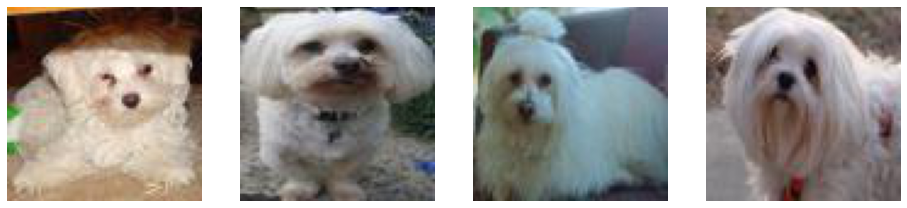

In [ ]:
i = 0
print(breed_list[i])
show_dir_images(breed_list[i], 4)

Generate the Matrix with the input data it will consist on a Matrix of:

- "X" rows: where "X" is the image pixels unrolled by its height and width and number of channels (RGB)
- "Y" columns: where "Y" is the number of images

In [ ]:
num_px = 80
matrix = []
labels = []
targets = []
for i, breed in enumerate(os.listdir(global_path + 'data/')): 
    if not breed.startswith('.'): 
        for file in os.listdir(global_path + 'Annotation/{}'.format(breed)):
            if not file.startswith('.'):
                img = imread(global_path + 'data/{}/{}.jpg'.format(breed, file))
                reshaped_img = np.reshape(img, [num_px*num_px*3, 1])
                matrix.append(reshaped_img)
                labels.append(breed)
                targets.append(label_maps[breed])
                

In [ ]:
X_mat = np.reshape(matrix, [len(matrix), num_px*num_px*3])
labels = np.reshape(labels, [len(matrix), 1])
targets = np.reshape(targets, [len(matrix), 1])
print(X_mat.shape)
print(labels.shape)
print(targets.shape)

(724, 19200)
(724, 1)
(724, 1)


n02085936-Maltese_dog
0


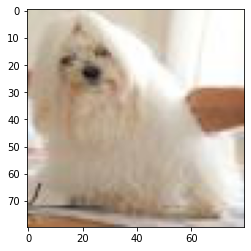

In [ ]:
i = 100
plt.imshow(np.reshape(X_mat[i, :], [num_px, num_px, 3]))
print(labels[i, 0])
print(targets[i, 0])

Preparing the data to give a good distribution/representation of the population. Shuffling and splitting the total amount of images into a train and test sets.

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X_mat, targets, test_size=0.20, shuffle= True)
x_train = x_train.T
y_train = y_train.T
x_valid = x_valid.T
y_valid = y_valid.T
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(19200, 579)
(1, 579)
(19200, 145)
(1, 145)


In [ ]:
def show_image(i, X, Y):
  plt.imshow(np.reshape(X[:, i], [num_px, num_px, 3]))
  print(Y[0, i])

0


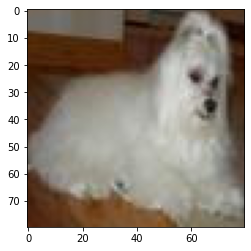

In [ ]:
show_image(9, x_train, y_train)

As my aim is to implement a Softmax function to multiclassification, the current labelling should be encoded through a one hot encoding function to prepare the labels accordingly.

In [ ]:
def one_hot_encoding(X, Y):
  one_hot_encoding = np.zeros((len(breed_list), X.shape[1]))
  c = np.zeros((1, 443))
  for i in range(0, len(breed_list)):
    c = Y == i
    one_hot_encoding[i] = c
  print(one_hot_encoding)
  print(one_hot_encoding.shape)
  Y = one_hot_encoding

  return Y



In [ ]:
y_train = one_hot_encoding(x_train, y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 1. 1. 0.]
 [0. 1. 0. ... 0. 0. 1.]]
(4, 579)


In [ ]:
y_valid = one_hot_encoding(x_valid, y_valid)

[[0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1.
  0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0.
  1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0.
  1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.
  1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
  0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 

[0. 0. 1. 0.]


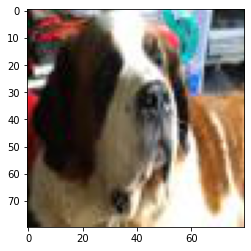

In [ ]:
i = 0
plt.imshow(np.reshape(x_train[:, i], [num_px, num_px, 3]))
print(y_train[:, i])

[0. 0. 1. 0.]


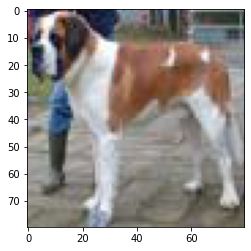

In [ ]:
i = 0
plt.imshow(np.reshape(x_valid[:, i], [num_px, num_px, 3]))
print(y_valid[:, i])

In [ ]:
#NORMALIZATION
x_train = x_train/255
x_valid = x_valid/255


# NEURAL NETWORK

based on the neural network from scratch on deeplearning specialization from deeplearning.ai

- momentum implemented
- minibatch implemented

In [ ]:
### Multilayer perceptron (layers & neurons) ###
layers_dims = [num_px*num_px*3, 9500, 1000, len(breed_list)] #  4-layer model
len(layers_dims)

4

In [ ]:
initialize_parameters_deep

def initialize_parameters_deep(layer_dims):

    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    

        
    return parameters

In [ ]:
# Parameters initialization

parameters = initialize_parameters_deep(layers_dims)

for l in range(1, len(layers_dims)):
  print(parameters["W" + str(l)].shape)

(9500, 19200)
(1000, 9500)
(4, 1000)


In [ ]:
#linear_forward

def linear_forward(A, W, b):

    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [ ]:
#linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):

    if activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache



In [ ]:
#L_model_forward

def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                 
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation = "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "softmax")
    caches.append(cache)
    
    assert(AL.shape == (len(breed_list),X.shape[1]))
            
    return AL, caches

In [ ]:
AL, caches = L_model_forward(x_train, parameters)
print("AL = " + str(AL))
print("Length of caches list = " + str(len(caches)))
AL.shape

AL = [[0.24864401 0.26874306 0.24875291 ... 0.28099631 0.27405963 0.26301257]
 [0.27724596 0.25213791 0.25380478 ... 0.24316877 0.2774652  0.25868726]
 [0.25367386 0.24684971 0.25840492 ... 0.23830065 0.25113048 0.24770274]
 [0.22043616 0.23226931 0.23903739 ... 0.23753427 0.19734469 0.23059743]]
Length of caches list = 3


(4, 579)

In [ ]:
# compute_cost

def compute_cost(AL, Y):

    m = Y.shape[1]

    cost = -np.sum(Y * np.log(AL + 1e-6))
    
    cost = np.squeeze(cost)    
    
    
    return cost



In [ ]:
compute_cost(AL, y_train)

print("cost = " + str(compute_cost(AL, y_train)))


cost = 802.4543244409148


In [ ]:
# linear_backward

def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*(np.sum(dZ, axis = 1, keepdims = True))
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [ ]:

# linear_activation_backward

def linear_activation_backward(dA, cache, Y, AL, activation):

    linear_cache, activation_cache = cache

    if activation == "softmax":
        dZ = softmax_backward(AL, Y, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [ ]:
# L_model_backward

def L_model_backward(AL, Y, caches):

    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    
    dAL =  -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (Softmax -> LINEAR) gradients. 
    current_cache = caches[L - 1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, Y, AL, activation = "softmax")
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache,Y, AL, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp


    return grads

In [ ]:
# initialize_velocity

def initialize_velocity(parameters):

    L = len(parameters) // 
    velocity = {}
    
    for l in range(L):
        velocity["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        velocity["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        
    return velocity

In [ ]:
# update_parameters

def update_parameters(parameters, grads, velocity, learning_rate):

    L = len(parameters) // 
    beta= 0.9

    for l in range(L):
        velocity["dW" + str(l+1)] = beta*velocity['dW' + str(l+1)] + (1-beta)*grads['dW' + str(l+1)]
        velocity["db" + str(l+1)] = beta*velocity['db' + str(l+1)] + (1-beta)*grads['db' + str(l+1)]

        parameters["W" + str(l+1)] = parameters['W' + str(l+1)] - learning_rate*velocity['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters['b' + str(l+1)] - learning_rate*velocity['db' + str(l+1)]

    return parameters, velocity

In [ ]:
# random_mini_batches

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    
    np.random.seed(seed)            
    m = X.shape[1]                  
    mini_batches = []
        
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((len(breed_list),m))

    # Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):

        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[:, k*mini_batch_size : m-mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : m-mini_batch_size]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [ ]:
# L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.05 , mini_batch_size = 32, num_iterations = 3000, print_cost=False):#lr was 0.009


    costs = []                         
    seed = 10 
    m = X.shape[1] 
    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)
    velocity = initialize_velocity(parameters)
    
    # gradient descent
    for i in range(0, num_iterations):

        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:
            
          (minibatch_X, minibatch_Y) = minibatch
          
          # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SOFTMAX.
          AL, caches = L_model_forward(minibatch_X, parameters)

          
          # Compute cost.
          cost_total += compute_cost(AL, minibatch_Y)

      
          # Backward propagation.
          grads = L_model_backward(AL, minibatch_Y, caches)

          # Update parameters.
          parameters, velocity = update_parameters(parameters, grads, velocity, learning_rate)
          
        cost_avg = cost_total/m
        
        # Print the cost every 2 training example and accuracies every 5
        if print_cost and i % 2 == 0:
            print ("Cost after iteration %i: %f" %(i, cost_avg))
        if print_cost and i % 1 == 0:
            costs.append(cost_avg)

        if print_cost and i % 5 == 0:
          count = 0
          for i in range(0, 579):
            probas, a = mypredict(np.reshape(x_train[:, i], [num_px*num_px*3, 1]), y_train, parameters)
            if a == np.argmax(y_train[:, i]):
              count = count +1
          print("accuracy in training set is" + " " + str(count/y_train.shape[1]))
          count = 0
          for i in range(0, 145):
            probas, a = mypredict(np.reshape(x_valid[:, i], [num_px*num_px*3, 1]), y_valid, parameters)
            if a == np.argmax(y_valid[:, i]):
              count = count +1
          print("accuracy in test set is" + " " + str(count/y_valid.shape[1]))
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [ ]:
def mypredict(X, y, parameters):

    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)
    
    a = np.argmax(probas, axis=0)
    
    
    return probas,a

Cost after iteration 0: 1.273899
accuracy in training set is 0.5664939550949913
accuracy in test set is 0.5586206896551724
Cost after iteration 2: 0.954898
Cost after iteration 4: 1.022140
accuracy in training set is 0.7357512953367875
accuracy in test set is 0.6551724137931034
Cost after iteration 6: 0.719727
Cost after iteration 8: 0.622767
Cost after iteration 10: 0.647049
accuracy in training set is 0.7582037996545768
accuracy in test set is 0.6344827586206897
Cost after iteration 12: 0.417296
Cost after iteration 14: 0.354377
accuracy in training set is 0.8860103626943006
accuracy in test set is 0.6344827586206897
Cost after iteration 16: 0.249276
Cost after iteration 18: 0.223447
Cost after iteration 20: 0.157938
accuracy in training set is 0.9792746113989638
accuracy in test set is 0.7172413793103448
Cost after iteration 22: 0.143367
Cost after iteration 24: 0.085878
accuracy in training set is 0.9395509499136442
accuracy in test set is 0.6551724137931034
Cost after iteration 26

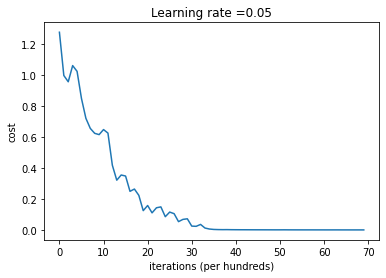

In [ ]:
parameters = L_layer_model(x_train, y_train, layers_dims, num_iterations = 70, print_cost = True)

In [ ]:
def accuracy(X, Y):
count = 0
for i in range(0, 579):
  probas, a = mypredict(np.reshape(X[:, i], [num_px*num_px*3, 1]), Y, parameters)
  if a == np.argmax(Y[:, i]):
    count = count +1
    
print(count/Y[1])

1.0


In [ ]:
accuracy(x_train, y_train)

[0. 1. 0. 0.]
n02099601-golden_retriever


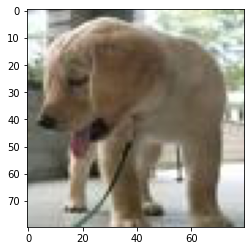

[0. 0. 1. 0.]
n02109525-Saint_Bernard


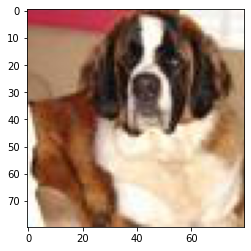

[0. 0. 0. 1.]
n02106662-German_shepherd


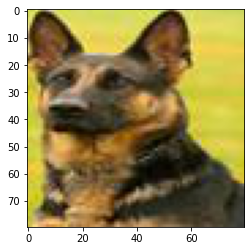

[0. 0. 1. 0.]
n02109525-Saint_Bernard


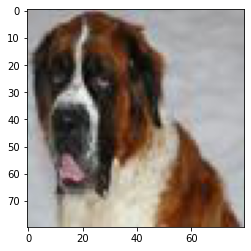

[1. 0. 0. 0.]
n02085936-Maltese_dog


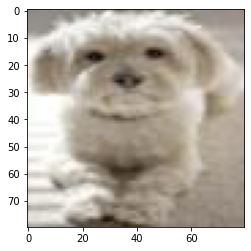

[0. 0. 0. 1.]
n02106662-German_shepherd


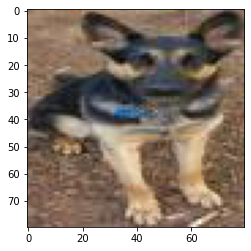

[0. 0. 0. 1.]
n02106662-German_shepherd


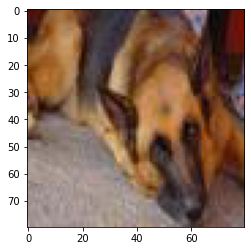

[0. 0. 0. 1.]
n02106662-German_shepherd


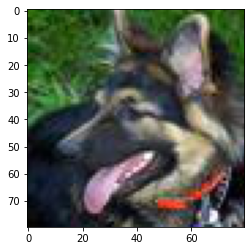

[0. 1. 0. 0.]
n02099601-golden_retriever


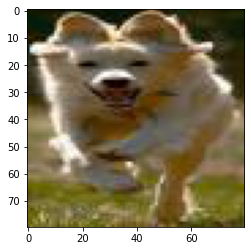

[0. 0. 0. 1.]
n02106662-German_shepherd


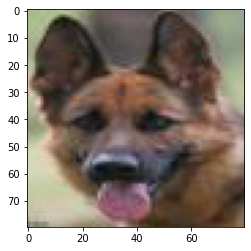

[0. 1. 0. 0.]
n02099601-golden_retriever


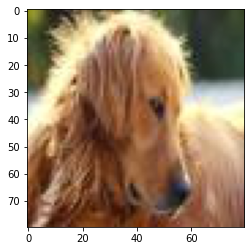

[0. 1. 0. 0.]
n02099601-golden_retriever


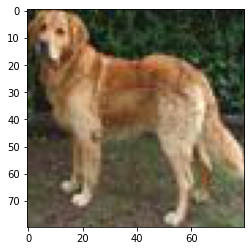

[0. 0. 1. 0.]
n02109525-Saint_Bernard


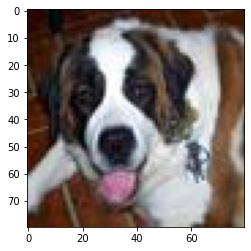

[1. 0. 0. 0.]
n02085936-Maltese_dog


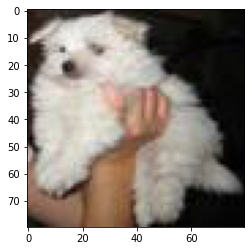

[1. 0. 0. 0.]
n02085936-Maltese_dog


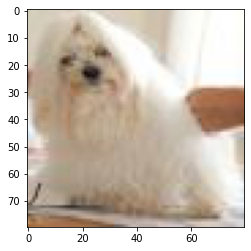

[0. 0. 1. 0.]
n02109525-Saint_Bernard


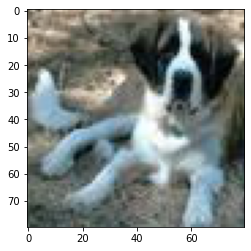

[0. 1. 0. 0.]
n02099601-golden_retriever


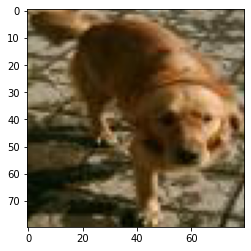

[1. 0. 0. 0.]
n02085936-Maltese_dog


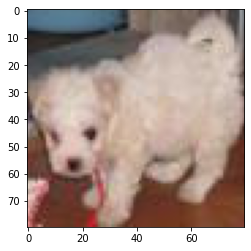

[0. 0. 0. 1.]
n02106662-German_shepherd


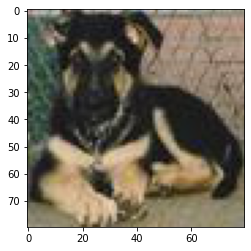

[1. 0. 0. 0.]
n02085936-Maltese_dog


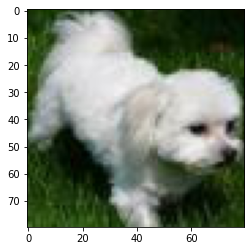

In [ ]:
def show results(X, Y, range_start, range_end):

for i in range (range_start, rage_end):   
    probas, a = mypredict(np.reshape(X[:, i], [19200, 1]), Y, parameters)
    plt.imshow(np.reshape(X[:, i], [80, 80, 3]))
    print(Y[:, i])
    if a == 0:
        print(breed_list[0])
    if a == 1:
        print(breed_list[1])
    if a == 2:
        print(breed_list[2])
    if a == 3:
        print(breed_list[3])

    plt.show()

In [ ]:
show results(x_train, y_train, 180, 200)

In [ ]:
accuracy(x_valid, y_valid)

[0. 0. 1. 0.]
n02109525-Saint_Bernard


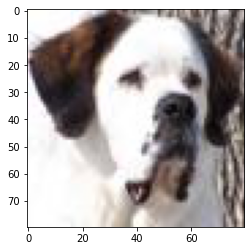

[0. 0. 0. 1.]
n02106662-German_shepherd


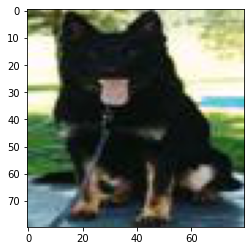

[0. 0. 1. 0.]
n02109525-Saint_Bernard


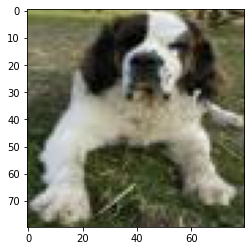

[1. 0. 0. 0.]
n02085936-Maltese_dog


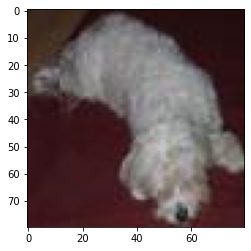

[0. 0. 0. 1.]
n02106662-German_shepherd


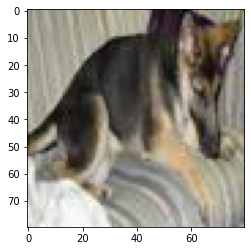

[1. 0. 0. 0.]
n02085936-Maltese_dog


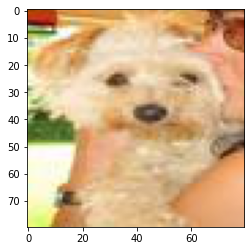

[1. 0. 0. 0.]
n02085936-Maltese_dog


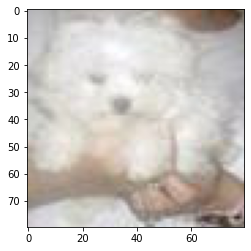

[1. 0. 0. 0.]
n02085936-Maltese_dog


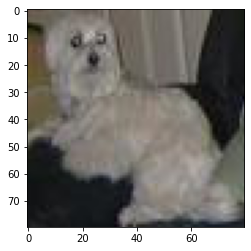

[1. 0. 0. 0.]
n02085936-Maltese_dog


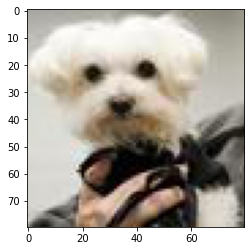

[0. 0. 1. 0.]
n02109525-Saint_Bernard


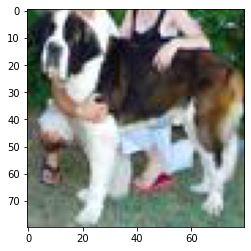

In [ ]:
show results(x_valid, y_valid, 100, 110)